In [1]:
# source source.me before launching jupyter
# export DWAVE_API_TOKEN=DEV-7dfad1c79ca4cac893a1541f6d04fbb3c2dced5c

In [13]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4
Fri Oct 13 15:43:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   42C    P0    67W / 275W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM... 

In [14]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [15]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [16]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[15:43:30.357] INFO   CaloQVAE                                          Willkommen!
[15:43:30.358] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

[13:23:09.335] INFO   numexpr.utils                                     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[13:23:09.335] INFO   numexpr.utils                                     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[13:23:09.336] INFO   numexpr.utils                                     NumExpr defaulting to 8 threads.
2023-09-25 13:23:09,752 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[13:23:09.752] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [6]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [7]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[21:06:53.236] INFO   data.dataManager                                  Loading Data
[21:06:59.685] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc4dad4ca10>: 96184 events, 752 batches
[21:06:59.686] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc4dad752d0>: 12023 events, 12 batches
[21:06:59.687] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc4dad4ca50>: 12023 events, 12 batches
[21:07:01.335] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasCRBMCNNDCond
2023-09-21 21:

Initializing NetworkV3


In [8]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
dev = torch.device("cuda:0")

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[21:07:04.493] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 533])
[21:07:04.493] INFO   wandb                                             Watching
/raid/javier/anaconda3/lib/python3.11/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[21:07:05.080] INFO   engine.engineAtlas                                Setting up engine Atlas.
[21:07:05.080] INFO   engine.engineCaloV3                               Setting up engine Calo.
[21:07:05.081] INFO   engine.engine                                     Setting up default engine.


In [9]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[21:07:12.292] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc467aa41d0>: 96184 events, 752 batches
[21:07:12.293] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc467a8c8d0>: 12023 events, 12 batches
[21:07:12.293] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc467a5ef50>: 12023 events, 12 batches


In [25]:
from dwave.system import DWaveSampler
qpu_sampler = DWaveSampler(solver={"topology__type":"pegasus"})
qpu_nodes = qpu_sampler.nodelist
qpu_edges = qpu_sampler.edgelist

2023-09-25 14:06:35,829 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[14:06:35.829] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2023-09-25 14:06:35,837 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[14:06:35.837] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2023-09-25 14:06:37,081 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[14:06:37.081] INFO   dwave.cloud.client.base                

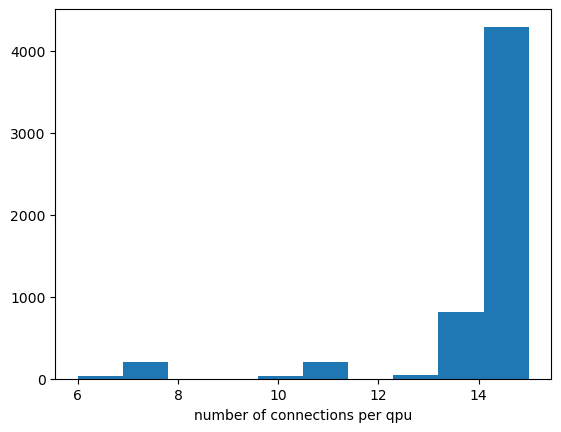

In [73]:
l = []
for node in qpu_nodes:
    l.append(len([tup for tup in qpu_edges if node in tup]))
plt.hist(l)
plt.xlabel("number of connections per qpu")
plt.show()

In [63]:
FourpGraph = dict()
FourpGraph["1"] = []
FourpGraph["2"] = []
FourpGraph["3"] = []
FourpGraph["4"] = []

FourpGraph["1"].append(qpu_nodes[0])
notIn1 = [n2 for n1,n2 in qpu_edges if FourpGraph["1"][0] == n1] + [n1 for n1,n2 in qpu_edges if FourpGraph["1"][0] == n2]


In [70]:
print(notIn1)
for node in notIn1:
    notIn2 = [n2 for n1,n2 in qpu_edges if node == n1] + [n1 for n1,n2 in qpu_edges if node == n2]
    notIn1n2 = [node2 for node2 in notIn2 if node2 in notIn1]
    print(node, notIn2, notIn1n2)

[31, 45, 2940, 2955, 2970, 2985]
31 [32, 46, 3120, 3135, 3150, 3165, 30] []
45 [46, 2940, 2955, 2970, 2985, 30] [2940, 2955, 2970, 2985]
2940 [2941, 2955, 30, 45, 180, 195] [2955, 45]
2955 [2956, 30, 45, 180, 195, 2940] [45, 2940]
2970 [2971, 2985, 30, 45, 120, 135, 150, 165, 180, 195] [2985, 45]
2985 [2986, 30, 45, 120, 135, 150, 165, 180, 195, 2970] [45, 2970]


In [62]:
[n2 for n1,n2 in qpu_edges if 45 == n1] + [n1 for n1,n2 in qpu_edges if 45 == n2]

[46, 2940, 2955, 2970, 2985, 30]

In [25]:
shft = qpu_sampler.nodelist[1]
ar = torch.zeros(np.max(qpu_sampler.nodelist)+1, np.max(qpu_sampler.nodelist)+1)
for node in qpu_sampler.nodelist:
    for adj in qpu_sampler.adjacency[node]:
        ar[node, adj] = 1
        ar[adj, node] = 1
    

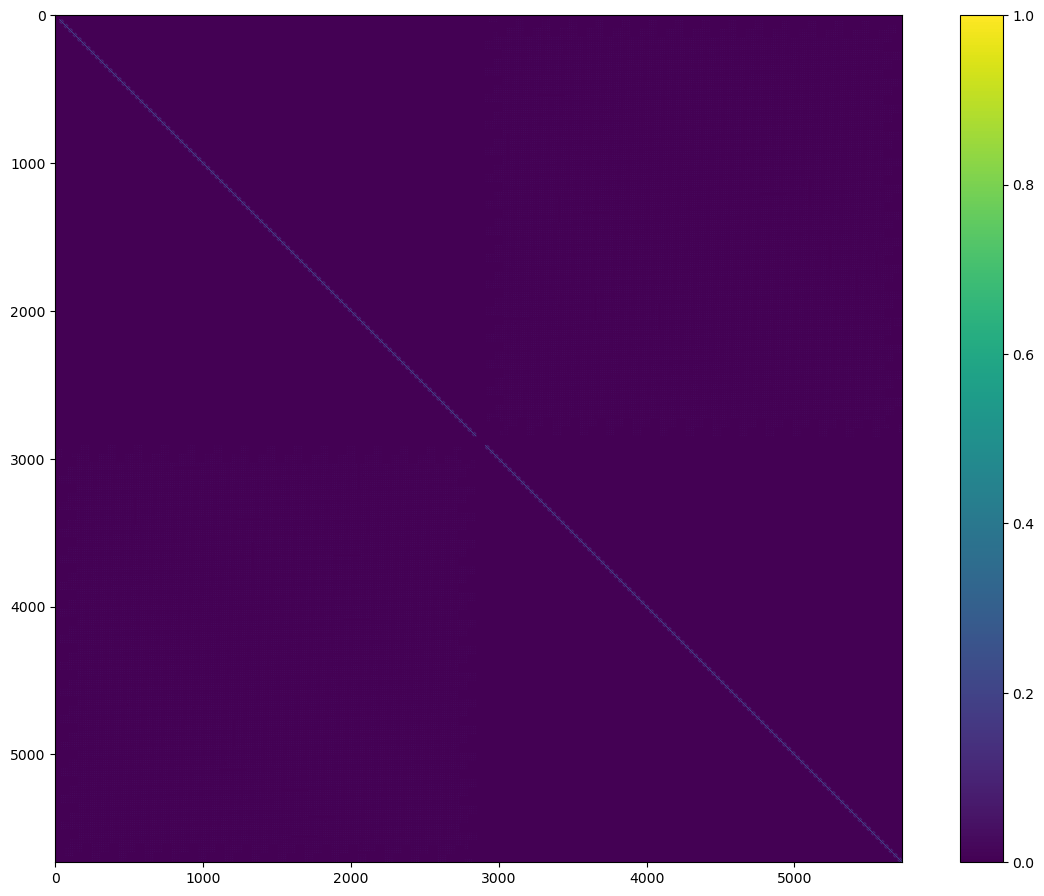

In [187]:
plt.figure(figsize=(15,11))
plt.imshow(ar.numpy())
plt.colorbar()

In [64]:
ar[1100:1110,:5410].sum(dim=1)

tensor([15., 15., 15., 15., 15., 15., 15., 15.,  3., 14.])

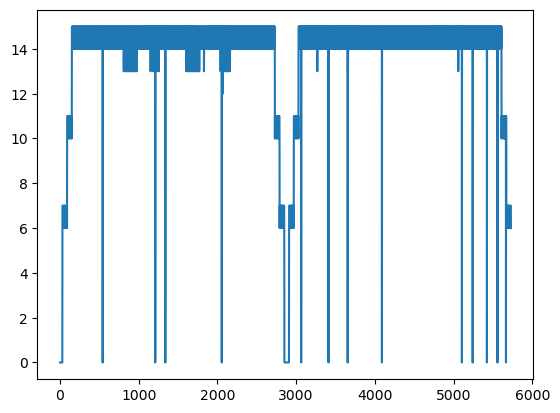

In [27]:
aa = ar.sum(dim=1).numpy()
plt.plot(aa)

In [291]:
qpu_edgelist = qpu_sampler.edgelist
qpu_nodelist = qpu_sampler.nodelist

# ar is the adj matrix
ar = torch.zeros(np.max(qpu_nodelist)+1, np.max(qpu_nodelist)+1)
# It's not clear if adjacency implies connection. Better to rely on edgelist = active couplings
# for node in qpu_sampler.nodelist:
#     for adj in qpu_sampler.adjacency[node]:
#         ar[node, adj] = 1
#         ar[adj, node] = 1

for (x,y) in qpu_edgelist:
    ar[x, y] = 1
    ar[y, x] = 1

# We select qbits with 15 connections each. ~4k
a = ar.sum(dim=1).sort()
t = a.indices[a.values >= 1]
idx = torch.randperm(t.shape[0])
arIdx15 = list(t[idx].numpy())
# arIdx15 = list(t.numpy())

In [322]:
# Abhi's idxs
arIdx15 = abhiIdxs

In [188]:
qpu_edgelist = qpu_sampler.edgelist
qpu_nodelist = qpu_sampler.nodelist

idx_dict, device = pp.gen_qubit_idx_dict()
ps = ["0","1","2","3"]
# Checks that no qbit in a given partition has connections with qbits in same partition
# If nothing gets printed => Good!
for p in ps:
    # print(p)
    for i in idx_dict[p]:
        checkTuples = [item for item in qpu_edgelist if i in item]
        for j in idx_dict[p]:
            if i != j:
                checkTuples2 = [item for item in checkTuples if j in item]
                assert checkTuples2 == []
                
                
l = []
for k,p in enumerate(ps):
    for q in ps[k+1:]:
        if p != q:
            l=[]
            # print(p,q)
            for i in idx_dict[p]:
                checkTuples = [item for item in qpu_edgelist if i in item]
                for j in idx_dict[q]:
                    if i != j:
                        l = l + [item for item in checkTuples if j in item]
            assert l != []

2023-09-25 20:09:42,091 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[20:09:42.091] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2023-09-25 20:09:42,099 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[20:09:42.099] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2023-09-25 20:09:43,124 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[20:09:43.124] INFO   dwave.cloud.client.base                

0
1
2
3
0 1
0 2
0 3
1 2
1 3
2 3


In [368]:
RBMtoQPUIdx = dict()
for p in ps:
    tmp = dict()
    for i, qbitIdx in enumerate(FourpGraph[p]):
        tmp[qbitIdx] = i
    RBMtoQPUIdx[p] = tmp
    


In [24]:
FourpGraph = dict()
FourpGraph["1"] = []
FourpGraph["2"] = []
FourpGraph["3"] = []
FourpGraph["4"] = []

gpu


p1 = 30
checkTuples = [item for item in qpu_sampler.edgelist if p1 in item]
checkTuples
p2 = 31
notInp1np2=[45,2940,2955,2970,2985]
for it in notInp1np2:
    checkTuples = [item for item in qpu_sampler.edgelist if it in item]
    print([item for item in checkTuples if p2 in item])
# checkTuples2 = [item for item in checkTuples if p2 in item]
# checkTuples2

[]
[]
[]
[]
[]


In [369]:
# We build RBM masking
weight_mask = dict()
weight_mask["01"] = torch.zeros(len(FourpGraph["1"]), len(FourpGraph["2"]))
weight_mask["02"] = torch.zeros(len(FourpGraph["1"]), len(FourpGraph["3"]))
weight_mask["03"] = torch.zeros(len(FourpGraph["1"]), len(FourpGraph["4"]))

weight_mask["12"] = torch.zeros(len(FourpGraph["2"]), len(FourpGraph["3"]))
weight_mask["13"] = torch.zeros(len(FourpGraph["2"]), len(FourpGraph["4"]))

weight_mask["23"] = torch.zeros(len(FourpGraph["3"]), len(FourpGraph["4"]))


c = []
for (x,y) in qpu_sampler.edgelist:
    if x in arIdx15 and y in arIdx15:
        if x in FourpGraph["1"]:
            n = 0
            pIdx = "1"
        elif x in FourpGraph["2"]:
            n = 1
            pIdx = "2"
        elif x in FourpGraph["3"]:
            n = 2
            pIdx = "3"
        elif x in FourpGraph["4"]:
            n = 3
            pIdx = "4"
        else:
            c.append(x)
            n = -1
            pIdx = "0"

        if y in FourpGraph["1"]:
            m = 0
            qIdx = "1"
        elif y in FourpGraph["2"]:
            m = 1
            qIdx = "2"
        elif y in FourpGraph["3"]:
            m = 2
            qIdx = "3"
        elif y in FourpGraph["4"]:
            m = 3
            qIdx = "4"
        else:
            c.append(y)
            m = -1
            qIdx = "0"

        if n != -1 and m != -1 and m != n and qIdx != "0" and pIdx != "0":
            key = str(min(n,m)) + str(max(n,m))
            if int(pIdx) < int(qIdx):
                weight_mask[key][RBMtoQPUIdx[pIdx][x], RBMtoQPUIdx[qIdx][y]] = 1
            else:
                weight_mask[key][RBMtoQPUIdx[qIdx][y], RBMtoQPUIdx[pIdx][x]] = 1

c = list(np.unique(c))
assert remainder0 == c

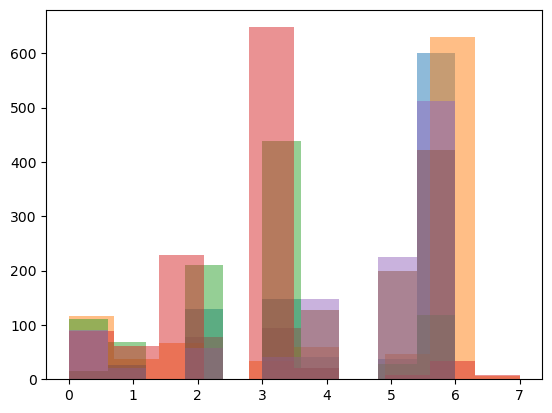

In [370]:
plt.hist(weight_mask['01'].sum(dim=1).numpy(), alpha = 0.5)
# plt.hist(weight_mask['02'].sum(dim=1).numpy(), alpha = 0.5)
# plt.hist(weight_mask['03'].sum(dim=1).numpy(), alpha = 0.5)
# plt.hist(weight_mask['12'].sum(dim=1).numpy(), alpha = 0.5)
# plt.hist(weight_mask['13'].sum(dim=1).numpy(), alpha = 0.5)
# plt.hist(weight_mask['23'].sum(dim=1).numpy(), alpha = 0.5)
plt.show()

In [371]:
weight_mask['01'].shape

torch.Size([998, 1095])

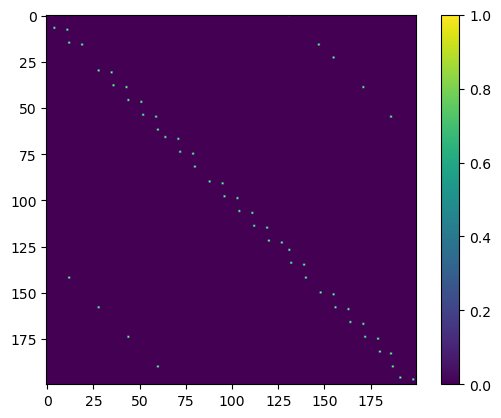

In [110]:
plt.imshow(engine.model.prior.weights_mask.abs().sign().detach().cpu().numpy()[:200,:200])
plt.colorbar()

(array([712.,   0.,   0.,   0.,   0., 183.,   0.,   0.,   0., 105.]),
 array([0.        , 0.2       , 0.40000001, 0.60000002, 0.80000001,
        1.        , 1.20000005, 1.39999998, 1.60000002, 1.79999995,
        2.        ]),
 <BarContainer object of 10 artists>)

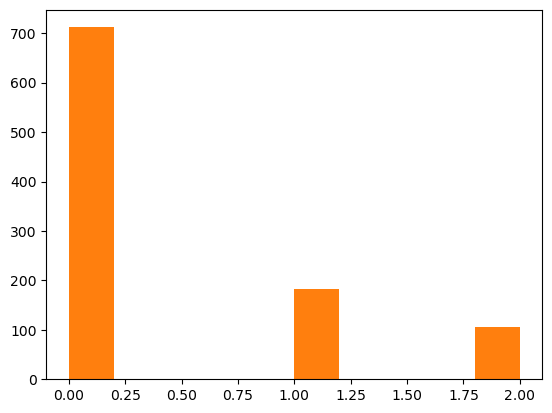

In [11]:
plt.hist(engine.model.prior.weights_mask.abs().sign().sum(dim=1).detach().cpu().numpy())
plt.hist(engine.model.prior.weights_mask.sum(dim=1).detach().cpu().numpy())

In [1]:
from models.rbm.pegasusRBM import PegasusRBM

In [2]:
pp = PegasusRBM(500)

40106 13965


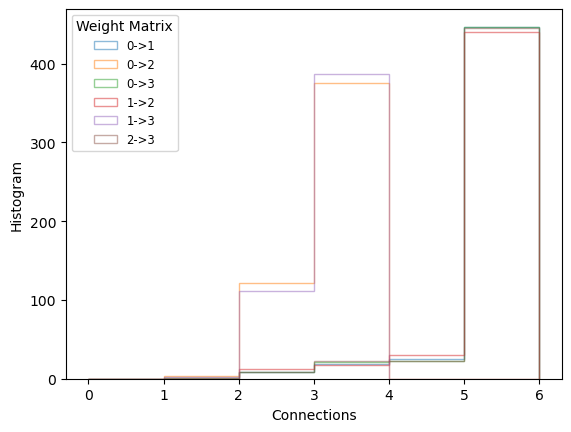

In [27]:

plt.hist(pp._weight_mask_dict['01'].sum(dim=1).numpy(), bins=np.arange(0, 6 + 1,1), alpha = 0.5,  histtype='step')
plt.hist(pp._weight_mask_dict['02'].sum(dim=1).numpy(), bins=np.arange(0, 6 + 1,1), alpha = 0.5,  histtype='step')
plt.hist(pp._weight_mask_dict['03'].sum(dim=1).numpy(), bins=np.arange(0, 6 + 1,1), alpha = 0.5,  histtype='step')
plt.hist(pp._weight_mask_dict['12'].sum(dim=1).numpy(), bins=np.arange(0, 6 + 1,1), alpha = 0.5,  histtype='step')
plt.hist(pp._weight_mask_dict['13'].sum(dim=1).numpy(), bins=np.arange(0, 6 + 1,1), alpha = 0.5,  histtype='step')
plt.hist(pp._weight_mask_dict['23'].sum(dim=1).numpy(), bins=np.arange(0, 6 + 1,1), alpha = 0.5,  histtype='step')
plt.legend(["0->1","0->2","0->3","1->2","1->3","2->3"], title="Weight Matrix",
                   fontsize='small', fancybox=True)
plt.xlabel("Connections")
plt.ylabel("Histogram")
plt.show()

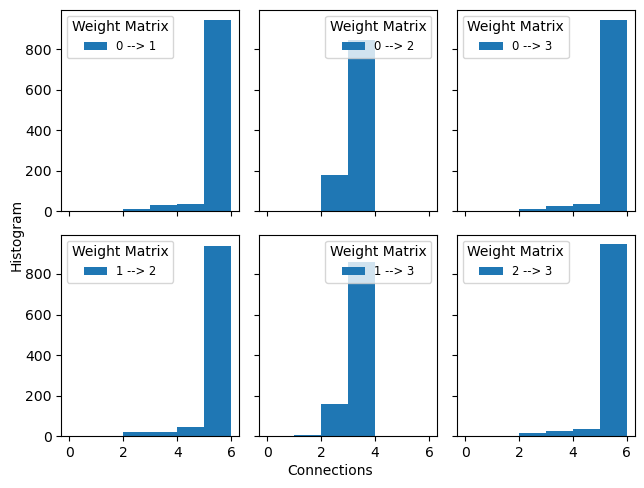

In [47]:
n_bins =  bins=np.arange(0, 6 + 1,1)
fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, 0.0, 'Connections', ha='center')
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical')

# We can set the number of bins with the *bins* keyword argument.
axs[0,0].hist(pp._weight_mask_dict['01'].sum(dim=1).numpy(), bins=n_bins)
axs[0,0].legend(["0 --> 1"], title="Weight Matrix",
                   fontsize='small', fancybox=True)
axs[0,1].hist(pp._weight_mask_dict['02'].sum(dim=1).numpy(), bins=n_bins)
axs[0,1].legend(["0 --> 2","0->3","1->2","1->3","2->3"], title="Weight Matrix",
                   fontsize='small', fancybox=True)
axs[0,2].hist(pp._weight_mask_dict['03'].sum(dim=1).numpy(), bins=n_bins)
axs[0,2].legend(["0 --> 3","1->2","1->3","2->3"], title="Weight Matrix",
                   fontsize='small', fancybox=True)
axs[1,0].hist(pp._weight_mask_dict['12'].sum(dim=1).numpy(), bins=n_bins)
axs[1,0].legend(["1 --> 2","1->3","2->3"], title="Weight Matrix",
                   fontsize='small', fancybox=True)
axs[1,1].hist(pp._weight_mask_dict['13'].sum(dim=1).numpy(), bins=n_bins)
axs[1,1].legend(["1 --> 3","2->3"], title="Weight Matrix",
                   fontsize='small', fancybox=True)
axs[1,2].hist(pp._weight_mask_dict['23'].sum(dim=1).numpy(), bins=n_bins)
axs[1,2].legend(["2 --> 3"], title="Weight Matrix",
                   fontsize='small', fancybox=True)
# plt.xlabel("Connections", fontsize='medium')
# plt.ylabel("Histogram")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/Pegasus_weight_matrices.png', dpi=300)
plt.show()

In [25]:
idx_dict, device = pp.gen_qubit_idx_dict()

2023-09-22 16:01:56,437 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[16:01:56.437] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2023-09-22 16:01:56,445 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[16:01:56.445] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2023-09-22 16:01:57,741 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[16:01:57.741] INFO   dwave.cloud.client.base                

In [27]:
idx_dict.keys()

dict_keys(['0', '1', '2', '3'])

In [321]:
abhiIdxs = torch.cat([torch.tensor(idx_dict[key]) for key in idx_dict.keys()]) #.sort().values
abhiIdxs = list(abhiIdxs.numpy())

In [1]:
from models.rbm.chimerav2 import QimeraRBM

[19:14:24.910] INFO   CaloQVAE                                          Willkommen!
[19:14:24.911] INFO   CaloQVAE                                          Loading configuration.


In [2]:
pp = QimeraRBM(500, 500)

2023-10-11 19:14:27,287 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[19:14:27.287] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2023-10-11 19:14:27,306 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[19:14:27.306] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2023-10-11 19:14:28,458 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[19:14:28.458] INFO   dwave.cloud.client.base                

40279 14005


2023-10-11 19:14:29,456 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[19:14:29.456] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2023-10-11 19:14:29,463 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[19:14:29.463] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2023-10-11 19:14:30,523 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[19:14:30.523] INFO   dwave.cloud.client.base                

In [3]:
pp.check_partition()

2023-09-25 20:35:09,861 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[20:35:09.861] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2023-09-25 20:35:09,869 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[20:35:09.869] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2023-09-25 20:35:11,158 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[20:35:11.158] INFO   dwave.cloud.client.base                

In [5]:
pp._weight_mask_dict['01'].shape
pp._weights_mask.shape

torch.Size([500, 500])

(array([  8.,   0.,  22.,   0.,   0.,  23.,   0.,  51.,   0., 396.]),
 array([2.        , 2.4000001 , 2.79999995, 3.20000005, 3.5999999 ,
        4.        , 4.4000001 , 4.80000019, 5.19999981, 5.5999999 ,
        6.        ]),
 <BarContainer object of 10 artists>)

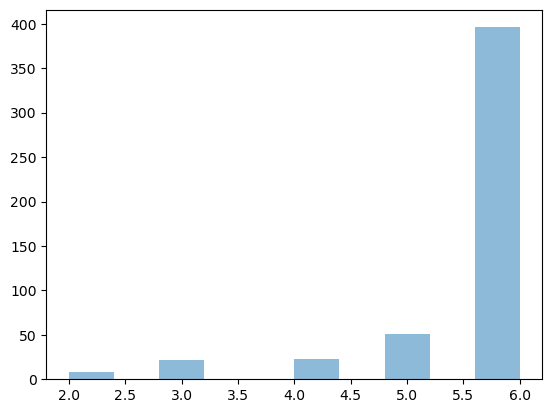

In [9]:
# len(pp._visible_qubit_idxs)
plt.hist(pp._weights_mask.sum(dim=1).numpy(), alpha = 0.5)

In [412]:
import dwave_networkx as dnx
_QPU_PSIZE = 16
coords = dnx.pegasus_coordinates(_QPU_PSIZE)

In [413]:
coords

In [6]:
# from models.rbm.pegasusRBM import PegasusRBM

In [7]:
idx_dict, device = pp.gen_qubit_idx_dict()

2023-10-11 19:04:57,925 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[19:04:57.925] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2023-10-11 19:04:57,932 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[19:04:57.932] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2023-10-11 19:04:59,023 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[19:04:59.023] INFO   dwave.cloud.client.base                

In [10]:
len(idx_dict['0'])

500

In [4]:
# pp._pruned_edge_list

In [1]:
from models.rbm.pegasusRBM import PegasusRBM
pp = PegasusRBM(1024, 1024)

(array([  2.,   0.,   0.,  14.,   0.,  28.,  36.,   0.,  71., 873.]),
 array([0.        , 0.60000002, 1.20000005, 1.79999995, 2.4000001 ,
        3.        , 3.5999999 , 4.19999981, 4.80000019, 5.4000001 ,
        6.        ]),
 <BarContainer object of 10 artists>)

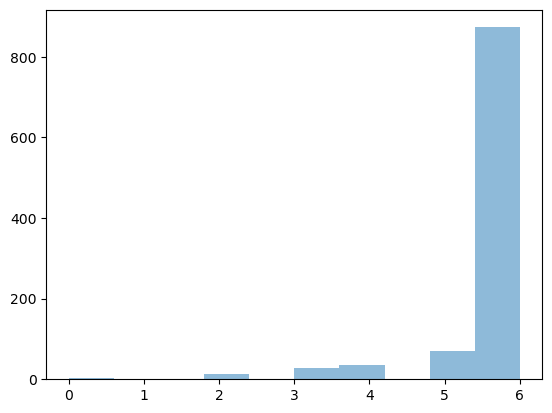

In [46]:
plt.hist(pp._weight_mask_dict['03'].sum(dim=1).detach().numpy(), alpha = 0.5)

In [2]:
idx_dict, device = pp.gen_qubit_idx_dict()

In [34]:
pp._weight_dict['01']

Parameter containing:
tensor([[-0.1800,  1.5024, -0.9996,  ..., -0.5866, -0.8730, -0.6517],
        [-0.3272,  1.6560,  1.3788,  ..., -1.3390,  0.4078, -0.5236],
        [ 0.0883, -0.3081,  0.5004,  ...,  1.6751,  0.7364, -0.2563],
        ...,
        [ 0.9896, -1.6735,  1.5186,  ...,  0.7461,  0.2363, -0.2526],
        [ 0.1347,  0.4132, -0.6481,  ..., -1.0558,  0.6566, -0.0722],
        [ 0.2270,  0.1936,  1.1882,  ...,  0.7399, -0.5303, -0.0849]],
       requires_grad=True)

In [3]:
pp.pruned_edge_list[1]

(60, 75)

In [4]:
pp._bias_dict.keys()

dict_keys(['0', '1', '2', '3'])

In [6]:
pp._weight_dict['01']

Parameter containing:
tensor([[-0.0127, -1.6568,  0.5628,  ...,  0.8362, -0.4078,  0.3532],
        [-0.5427, -0.3184,  0.7055,  ...,  0.6308,  1.2405, -0.3343],
        [-0.4144,  0.0149, -0.7097,  ...,  0.3694,  1.0227,  0.7156],
        ...,
        [-0.7958, -0.1339,  0.5282,  ...,  0.3011, -0.5981, -0.0990],
        [-1.9000,  1.2656,  0.0517,  ..., -0.6025, -1.2480,  0.1977],
        [-1.6291,  0.7548,  0.1256,  ...,  0.1625, -1.6784, -0.2475]],
       requires_grad=True)

In [10]:
# pp.

In [18]:
# int('0')
a = torch.rand(10)

In [23]:
torch.zeros(a.size(), device=a.device)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [22]:
a.device

device(type='cpu')

In [24]:
import numpy as np

In [28]:
str(np.min([1,2])) + str(np.max([1,2]))

'12'

In [30]:
torch.cat([torch.rand(10), torch.zeros(10)])

tensor([0.4967, 0.9308, 0.3677, 0.2049, 0.6646, 0.3886, 0.0787, 0.1447, 0.1809,
        0.6440, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])

In [31]:
torch.cat([a for i in range(2)])

tensor([0.9485, 0.5219, 0.8782, 0.7254, 0.6929, 0.0259, 0.9319, 0.0913, 0.7177,
        0.7271, 0.9485, 0.5219, 0.8782, 0.7254, 0.6929, 0.0259, 0.9319, 0.0913,
        0.7177, 0.7271])

In [8]:
# pp.gen_qubit_idx_dict()
pp._qpu_sampler.properties["chip_id"]

'Advantage_system4.1'